<img src='https://www.actris.eu/sites/default/files/inline-images/Actris%20logo.png' width=200 align=right>

# ACTRIS DC 
## Equivalent black carbon (eBC)

Equivalent black carbon (eBC) is used to describe carbon mass derived from the aerosol absorption coefficient. The aerosol absorption coefficient is measured using filter absorption photometers, such as AE33, MAAP, CLAP etc. In this example eBC is calculated using the aerosol absorption coefficient at 637 nm. If no such wavelength exists, an extrapolation using the two closest wavelengths and the Ångström exponent is performed. The aerosol absorption coefficient is then devided by a mass absorption coefficient (MAC) to aqcuire equivalent black carbon mass concentration (µg/m$^3$)

A mass absorption coefficient (MAC) value of 10.0 m$^2$ g$^{-1}$ (geometric standard deviation = 1.33) at a wavelength of 637 nm can be considered to be representative of the mixed boundary layer at European background
sites, where BC is expected to be internally mixed to a large extent. [1] 

##### References: 

[1] M. Zanatta, M. Gysel, N. Bukowiecki, T. Müller, E. Weingartner, H. Areskoug, M. Fiebig, K.E. Yttri, N. Mihalopoulos, G. Kouvarakis, D. Beddows, R.M. Harrison, F. Cavalli, J.P. Putaud, G. Spindler, A. Wiedensohler, A. Alastuey, M. Pandolfi, K. Sellegri, E. Swietlicki, J.L. Jaffrezo, U. Baltensperger, P. Laj, A European aerosol phenomenology-5: Climatology of black carbon optical properties at 9 regional background sites across Europe,
Atmospheric Environment, Volume 145, 2016, Pages 346-364, ISSN 1352-2310, https://doi.org/10.1016/j.atmosenv.2016.09.035.

In [2]:
import xarray as xr 
import netCDF4 as nc 
import threddsclient
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import statistics

### Access NRT filter absorption photometer data

In [3]:
# Get the ACTRIS NRT thredds catalog
all_opendap_urls = threddsclient.opendap_urls('https://thredds.nilu.no/thredds/catalog/actris_nrt/catalog.xml')

# Get all filter absorption photometer opendap urls
fap_opendap_urls = [x for x in all_opendap_urls if 'filter_absorption_photometer' in x]
fap_opendap_urls = [x for x in fap_opendap_urls if 'BG0001R' in x]
print('All NRT filter_absorption_photometer datasets with opendap protocol: \n',fap_opendap_urls)

All NRT filter_absorption_photometer datasets with opendap protocol: 
 ['https://thredds.nilu.no/thredds/dodsC/actris_nrt/BG0001R.20230814050000.20231114043620.filter_absorption_photometer..aerosol.3mo.1h.BG02L_GMD_CLAP-3W_BEO_NRT.BG02L_abs_coef.lev1.5.nc']


In [4]:
# For this example only one opendap_url is used: 
opendap_url = fap_opendap_urls[-1]
opendap_url

'https://thredds.nilu.no/thredds/dodsC/actris_nrt/BG0001R.20230814050000.20231114043620.filter_absorption_photometer..aerosol.3mo.1h.BG02L_GMD_CLAP-3W_BEO_NRT.BG02L_abs_coef.lev1.5.nc'

In [5]:
# Open and show dataset with xarray 
ds_xr = xr.open_dataset(opendap_url)
ds_xr

<xarray.Dataset>
Dimensions:                                               (time: 2104,
                                                           tbnds: 2,
                                                           metadata_time: 1,
                                                           Location: 1,
                                                           pressure_qc_flags: 2,
                                                           temperature_qc_flags: 1,
                                                           Wavelength: 3,
                                                           aerosol_absorption_coefficient_amean_qc_flags: 1,
                                                           aerosol_absorption_coefficient_prec1587_qc_flags: 1,
                                                           aerosol_absorption_coefficient_perc8413_qc_flags: 1)
Coordinates:
  * time                                                  (time) datetime64[ns] ...
  * metadata_time                                         (metadata_time) datetime64[ns] ...
  * Location                                              (Location) |S64 b'i...
  * Wavelength                                            (Wavelength) float64 ...
Dimensions without coordinates: tbnds, pressure_qc_flags, temperature_qc_flags,
                                aerosol_absorption_coefficient_amean_qc_flags,
                                aerosol_absorption_coefficient_prec1587_qc_flags,
                                aerosol_absorption_coefficient_perc8413_qc_flags
Data variables: (12/17)
    time_bnds                                             (time, tbnds) datetime64[ns] ...
    metadata_time_bnds                                    (metadata_time, tbnds) datetime64[ns] ...
    pressure_qc                                           (Location, pressure_qc_flags, time) float64 ...
    pressure_ebasmetadata                                 (Location, metadata_time) |S64 ...
    temperature_qc                                        (Location, temperature_qc_flags, time) float64 ...
    temperature_ebasmetadata                              (Location, metadata_time) |S64 ...
    ...                                                    ...
    aerosol_absorption_coefficient_perc8413_ebasmetadata  (Wavelength, metadata_time) |S64 ...
    pressure                                              (Location, time) float64 ...
    temperature                                           (Location, time) float64 ...
    aerosol_absorption_coefficient_amean                  (Wavelength, time) float64 ...
    aerosol_absorption_coefficient_prec1587               (Wavelength, time) float64 ...
    aerosol_absorption_coefficient_perc8413               (Wavelength, time) float64 ...
Attributes: (12/100)
    Conventions:                     CF-1.8, ACDD-1.3
    featureType:                     timeSeries
    title:                           Ground based in situ observations of fil...
    keywords:                        aerosol_absorption_coefficient, GAW-WDCA...
    id:                              BG0001R.20230814050000.20231114043620.fi...
    naming_authority:                EBAS
    ...                              ...
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    comment:                         {\n    "Data definition": "EBAS_1.1",\n ...
    standard_name_vocabulary:        CF-1.7, ACDD-1.3
    history:                         None
    creator_url:                     ebas.nilu.no

### Calculate eBC from aerosol absorption coefficient

In [8]:
# Calculate the closest wavelength to 637.0 nm. This is the wavelength used to calculate eBC.
given_wavelength = 637. 
all_wavelengths = ds_xr.Wavelength.values

closest_wavelength = min(all_wavelengths, key=lambda x:abs(x-given_wavelength))
closest_wavelength

652.0

In [9]:
# Find the index of the second closest wavelength 
cw_index = np.where(all_wavelengths==closest_wavelength)[0][0]
if closest_wavelength > given_wavelength: 
    scw_index = cw_index-1
    print(all_wavelengths[cw_index], all_wavelengths[scw_index])
elif closest_wavelength < given_wavelength: 
    scw_index = cw_index+1
    print(all_wavelengths[cw_index], all_wavelengths[scw_index])
else: 
    # No need for second closest wavelength as the closest wavelength is 637.0 nm
    scw_index = False
    print(all_wavelengths[cw_index])

652.0 528.0


In [13]:
# Create datasets with the aerosol absorption coefficient for the wavelength(s)

ab = ds_xr["aerosol_absorption_coefficient_amean"] 
ab_cw = ab.sel(Wavelength = all_wavelengths[cw_index]) 
if scw_index != False: 
    ab_scw = ab.sel(Wavelength = all_wavelengths[scw_index])
ab_cw

<xarray.DataArray 'aerosol_absorption_coefficient_amean' (time: 2104)>
[2104 values with dtype=float64]
Coordinates:
  * time        (time) datetime64[ns] 2023-08-14T05:30:00 ... 2023-11-14T01:3...
    Wavelength  float64 652.0
Attributes: (12/48)
    standard_name:                   volume_absorption_coefficient_in_air_due...
    units:                           1/Mm
    ancillary_variables:             aerosol_absorption_coefficient_amean_qc ...
    cell_methods:                    time: mean
    ebas_data_license:               https://creativecommons.org/licenses/by/...
    ebas_revision_date:              20231114043620
    ...                              ...
    ebas_framework_description:      ACTRIS is the European Research Infrastr...
    ebas_framework_contact_name:     Cathrine Lund Myhre, Markus Fiebig, Mark...
    ebas_framework_contact_email:    clm@nilu.no, Markus.Fiebig@nilu.no, Mark...
    ebas_originator:                 Kalapov, Ivo Emilov, , , , , , , , , 
    ebas_submitter:                  Kalapov, Ivo Emilov, , , , , , , , , 
    ebas_acknowledgement:            Request acknowledgement details from dat...

In [17]:
"""
Calculate Ångström coefficient from the two closest wavelengths and aerosol absorption coefficients to 637.0nm

Parameters:
    sigma1      aerosol absorption coefficient for lambda1
    sigma2      aerosol absorption coefficient for lambda2
    lambda1     wavelength nr. 1
    lambda2     wavelength nr. 2

Returns:
    Ångström coefficient (angstrom_lambda1_lambda2)
"""

def angstrom(sigma1,sigma2,lambda1, lambda2):
    # For a smooth operation, check that datasets are even in size.
    if len(sigma1) == len(sigma2):
        A = len(sigma1)
    else:
        return print("Match length of datasets.")
    
    alpha = np.zeros(A) # empty array with length of dataset
    
    for i in range(A):
        # checking for NaNs and negative numbers
        if np.isnan(sigma1[i]) or np.isnan(sigma2[i]):
            alpha[i] = np.nan
        if sigma1[i] < 0 or sigma2[i] < 0:
            alpha[i] = np.nan
        else:
            alpha[i] = (np.log(sigma2[i]/sigma1[i]))/(np.log(lambda1/lambda2))
        time = sigma1.index
    return time, alpha

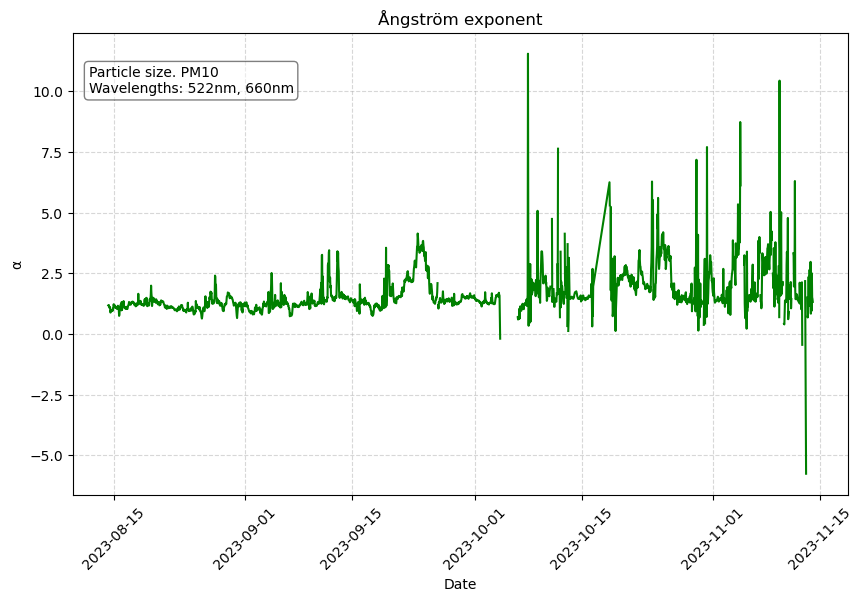

In [24]:
if scw_index != False: 
    #Create dataframes for plotting
    ab_cw_df = ab_cw.to_dataframe()
    ab_scw_df = ab_scw.to_dataframe()
    lambda_cw = all_wavelengths[cw_index]
    lambda_scw = all_wavelengths[scw_index]

    time, alpha = angstrom(ab_cw_df["aerosol_absorption_coefficient_amean"], ab_scw_df["aerosol_absorption_coefficient_amean"],lambda_cw, lambda_scw)

    # Plot the Ångström exponent 
    plt.figure(figsize=(10,6))
    plt.plot(time, alpha, color='g')
    plt.xticks(rotation=45)
    plt.title("Ångström exponent")
    plt.xlabel("Date")
    plt.ylabel("α")
    plt.gca().set_facecolor('white')
    plt.grid(True, linestyle='--', alpha=0.5)
    text_box_props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(0.02, 0.87, 'Particle size. PM10\nWavelengths: 522nm, 660nm', transform=plt.gca().transAxes, bbox=text_box_props)

    plt.show()

In [37]:
"""
Calculate aerosol absorption coefficients at 637.0nm

Parameters:
    alpha       Ångström exponent
    sigma       Known Aerosol Absorption Coefficient, depending on what you calculated the exponent for.
    lambda_s    Wavelength for sigma
    lambda_a    Wavelength you want to find the coefficient for, here 637.0 nm
    precision   precision (digits)

Returns:
    Aerosol Absorption Coefficients at 637.0nm (abs_coeff)
"""
def calculate_abs_coeff(alpha, sigma, lambda_s, lambda_a):
    abs_coeff = np.zeros(len(alpha))
    for i in range(len(alpha)):
        abs_coeff[i] = ((lambda_a/lambda_s)**(-alpha[i]))*sigma[i]
    time = sigma.index
    return time, abs_coeff

In [38]:
if scw_index != False: 
    # Executing the function for deriving absoprtion coefficient at wanted wavelength
    time, abs_coeff637 = calculate_abs_coeff(alpha, ab_cw_df["aerosol_absorption_coefficient_amean"], given_wavelength, lambda_cw)

    df_ab637 = pd.DataFrame(abs_coeff637, time) # making into dataframe
    df_ab637.columns = ["estimated_aerosol_absorption_coefficient"]

    print(df_ab637)

                     estimated_aerosol_absorption_coefficient
time                                                         
2023-08-14 05:30:00                                  1.737053
2023-08-14 06:30:00                                  1.642346
2023-08-14 07:30:00                                  1.302438
2023-08-14 08:30:00                                  1.460405
2023-08-14 09:30:00                                  1.242408
...                                                       ...
2023-11-13 21:30:00                                  0.034989
2023-11-13 22:30:00                                  0.053611
2023-11-13 23:30:00                                  0.114828
2023-11-14 00:30:00                                  0.128092
2023-11-14 01:30:00                                  0.168668

[2104 rows x 1 columns]


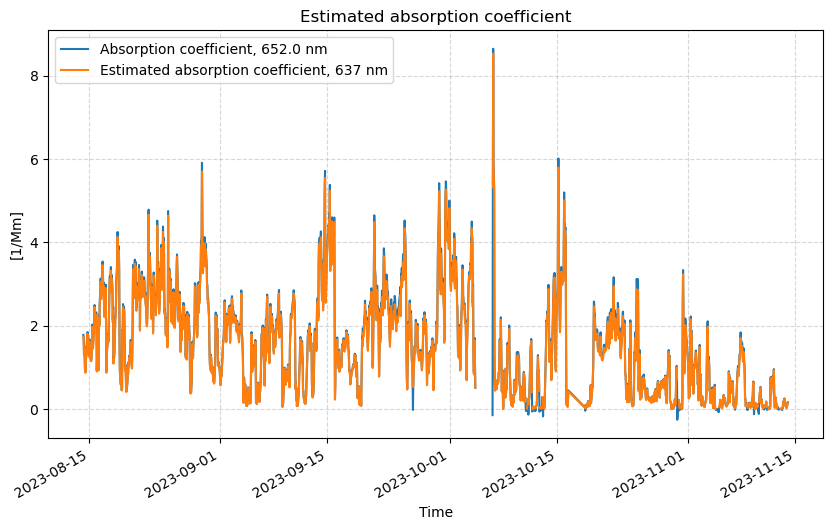

In [55]:
if scw_index != False:
    # Plot of extrapolated aerosol absorption coefficient at 637.0 nm compared to aerosol absorption coefficient at closest wavelength
    # This is a check that the extrapolation is correct
    fig, ax = plt.subplots(figsize=(10,6))

    ab_cw_df["aerosol_absorption_coefficient_amean"].plot(ax=ax, label="Absorption coefficient, {} nm".format(lambda_cw))
    #ab_scw_df["aerosol_absorption_coefficient_amean"].plot(ax=ax, label="Estimated absorption coefficient, {}nm".format(lambda_scw))
    if scw_index != False: 
        df_ab637["estimated_aerosol_absorption_coefficient"].plot(ax=ax, label="Estimated absorption coefficient, 637 nm")

    plt.title("Estimated absorption coefficient")
    plt.xlabel("Time")
    plt.ylabel("[1/Mm]")

    plt.gca().set_facecolor('white')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.legend()
    plt.show()

In [66]:
if scw_index != False: 
    # Convert from dataframe to Data Array with correct wavelength
    da_ab637 = df_ab637.to_xarray().assign_coords({"Wavelength": (637.0)}).estimated_aerosol_absorption_coefficient
elif scw_index == False:
    da_ab637 = ab_cw_df["aerosol_absorption_coefficient_amean"].to_xarray().assign_coords({"Wavelength": (637.0)})
da_ab637

<xarray.DataArray 'aerosol_absorption_coefficient_amean' (time: 2104)>
array([1.785067, 1.688422, 1.338874, ..., 0.118927, 0.132443, 0.173918])
Coordinates:
  * time        (time) datetime64[ns] 2023-08-14T05:30:00 ... 2023-11-14T01:3...
    Wavelength  float64 637.0

In [68]:
# Calculate equivalent black carbon from aerosol absorption coefficient. 
MAC = 10.0 #m2 g-1

da_eBC = (da_ab637/MAC).rename('eBC')

da_eBC

<xarray.DataArray 'eBC' (time: 2104)>
array([0.1785067, 0.1688422, 0.1338874, ..., 0.0118927, 0.0132443,
       0.0173918])
Coordinates:
  * time        (time) datetime64[ns] 2023-08-14T05:30:00 ... 2023-11-14T01:3...
    Wavelength  float64 637.0

### Plot of equivalent black carbon

In [69]:
# Convert xarray's DataArray to pandas DataFrame and plot data.
df_eBC = da_eBC.to_dataframe()

fig = px.line(df_eBC.eBC)


fig.update_layout(
    title="{0}".format(ds_xr.title),
    xaxis_title="Time",
    yaxis_title="µg/m3 (equivalent black carbon)",
    font=dict(
        family="Courier New, monospace",
        size=11,
        color="RebeccaPurple"
    ),
    legend=dict(
        title='Calculated at {0} nm:'.format(da_eBC.Wavelength.values)
    )
)
fig.show()

### Daily mean

In [70]:
# resample to daily and monthly mean values
df_day = df_eBC.eBC.resample('D').mean()
df_month = df_eBC.eBC.resample('M').mean()

In [71]:
daily_mean = df_day.iloc[-1:].to_dict()

# create variables for daily mean
sample_date_daily_mean = list(daily_mean.keys())[0]
sample_value_daily_mean = round(list(daily_mean.values())[0],6)
print('Daily mean for',sample_date_daily_mean,', eBC =', sample_value_daily_mean, 'µg/m3')

Daily mean for 2023-11-14 00:00:00 , eBC = 0.015318 µg/m3


### Monthly mean

In [72]:
monthly_mean = df_month.iloc[-2:-1].to_dict()

# create variables for monthly mean
sample_date_monthly_mean = list(monthly_mean.keys())[0]
sample_value_monthly_mean = round(list(monthly_mean.values())[0],6)
print('Monthly mean for',sample_date_monthly_mean.month_name(),', eBC =', sample_value_monthly_mean, 'µg/m3')

Monthly mean for October , eBC = 0.128732 µg/m3


### Last 3 months

In [73]:
last3months = statistics.mean(list(df_month.to_dict().values())[0:3])

# create variables for daily mean
sample_date_last3months_mean = list(df_month.to_dict().keys())
sample_value_last3months_mean = round(last3months,6)

sample_date_last3months_mean = "{0} - {1}".format(sample_date_last3months_mean[0].month_name(),sample_date_last3months_mean[2].month_name())

print('Last 3 months (',sample_date_last3months_mean,'), eBC =', sample_value_last3months_mean, 'µg/m3')

Last 3 months ( August - October ), eBC = 0.183278 µg/m3
